# General data analysis

Data analysis at city level based on the results for the 15 minute city methodology. This will include
* Average time within each city
* Main missing amenity
* Population percentage by time range
* Average time to each amenity
* Marginalization vs time

## Import libraries

In [65]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Donwload data

Donwload hexagon and time data from specified cities

In [49]:
cities = ['ZMVM','Guadalajara',
         'Monterrey','Cancun','Tijuana',
         'Leon','Morelia','Aguascalientes',
         'Merida','Pachuca','Toluca','Queretaro']

In [50]:
cities = str(tuple(cities))
schema = 'prox_analysis'
table = 'time_15_min_analysis_hexres8'
cve_column = 'city'
query = f'SELECT * FROM {schema}.{table} WHERE "{cve_column}" IN {cities}'

In [51]:
gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(gdf.shape)
gdf.head(2)

(11787, 30)


,hex_id_8,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,max_idx_15_min,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pobha,city
0,88498e36dbfffff,"POLYGON ((-102.34777 21.92336, -102.34267 21.9...",15.057619,13.586498,15.057619,11.969535,62.167866,53.640209,50.912589,62.167866,...,71.010665,264.7125,131.68126,133.03125,75.937500,50.962500,117.731249,20.081251,3.063433,Aguascalientes
1,88498e36d5fffff,"POLYGON ((-102.32839 21.92505, -102.32329 21.9...",41.764955,22.511213,23.594408,41.764955,49.597804,49.597804,23.166648,33.483284,...,49.597804,1040.9625,542.34850,498.61400,142.968993,171.018986,497.508140,228.414930,12.047757,Aguascalientes


## Data analysis

### Time by city

In [52]:
gdf['wgt_max_idx_15_min'] =(gdf['max_idx_15_min'] * gdf['pobtot'])/gdf.groupby('city')['pobtot'].transform('sum')
gdf[['city','wgt_max_idx_15_min']].groupby('city').sum()

,wgt_max_idx_15_min
city,
Aguascalientes,65.877561
Cancun,54.194363
Guadalajara,66.390274
Leon,55.227166
Merida,67.633569
Monterrey,59.527438
Morelia,66.309843
Pachuca,71.822048
Queretaro,84.979096


In [53]:
gdf[['city','max_idx_15_min']].groupby('city').mean()

,max_idx_15_min
city,
Aguascalientes,92.188233
Cancun,89.989521
Guadalajara,101.027956
Leon,83.591583
Merida,97.604972
Monterrey,82.695496
Morelia,102.357382
Pachuca,108.585525
Queretaro,130.847397


### Main missing ammenity

In [54]:
lista_amenidades = ['max_preescolar','max_primaria',
                    'max_secundaria','max_salud','max_guarderías',
                    'max_asistencia social','max_alimentos','max_personal',
                    'max_farmacias','max_hogar','max_complementarios','max_social',
                    'max_actividad física', 'max_cultural']

missing_column_name = 'Equipamiento/servicio prioritario'

gdf[missing_column_name] = 'No aplica'
idx = gdf['max_idx_15_min']>15
gdf.loc[idx,missing_column_name] = gdf[lista_amenidades].idxmax(axis=1)

In [55]:
gdf_equipamiento = gdf[['city',missing_column_name]].groupby('city').value_counts().reset_index().rename(columns={0:'contador'})
gdf_equipamiento = gdf_equipamiento.groupby('city').max().reset_index().drop(columns=[missing_column_name]).merge(gdf_equipamiento, on=['city','contador'])
gdf_equipamiento['pct_max'] = gdf_equipamiento['contador'] / len(gdf)
gdf_equipamiento

,city,contador,Equipamiento/servicio prioritario,pct_max
0,Aguascalientes,494,max_cultural,0.041911
1,Cancun,189,max_cultural,0.016035
2,Guadalajara,924,max_cultural,0.078391
3,Leon,365,max_cultural,0.030966
4,Merida,369,max_cultural,0.031306
5,Monterrey,902,max_cultural,0.076525
6,Morelia,215,max_cultural,0.018240
7,Pachuca,217,max_cultural,0.018410
8,Queretaro,332,max_cultural,0.028167
9,Tijuana,870,max_cultural,0.073810


### Population by time range

In [77]:
def index_time_group(time_column):
    if time_column <= 15:
        time_group = '0-15min'
    elif time_column <= 30:
        time_group = '15-30min'
    elif time_column <= 45:
        time_group = '30-45min'
    elif time_column <= 60:
        time_group = '45-60min'
    else:
        time_group = '> 60min'
    return time_group

In [78]:
gdf['time_group'] = gdf.max_idx_15_min.apply(index_time_group)

In [79]:
gdf_group = gdf.groupby(['city','time_group']).sum()
gdf_group = gdf_group['pobtot'].copy()
gdf_group = gdf_group.reset_index()
gdf_group['pct_pobtot'] = 100 * gdf_group['pobtot'] / gdf_group.groupby('city')['pobtot'].transform('sum')

In [80]:
gdf_group.head(4)

,city,time_group,pobtot,pct_pobtot
0,Aguascalientes,0-15min,115366.130400,5.535238
1,Aguascalientes,15-30min,348757.629800,16.733305
2,Aguascalientes,30-45min,376762.852740,18.076988
3,Aguascalientes,45-60min,329284.650234,15.798996


In [81]:
#categorical data
cat_list = ['0-15min','15-30min','30-45min', 
            '45-60min','> 60min']

cat_size_order = CategoricalDtype(
    cat_list, 
    ordered=True)

gdf_group['time_group'] = gdf_group['time_group'].astype(cat_size_order)
gdf_group = gdf_group.sort_values('time_group')

<AxesSubplot:xlabel='time_group', ylabel='pct_pobtot'>

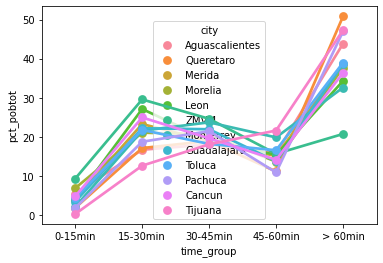

In [82]:
sns.pointplot(data=gdf_group, x="time_group", y="pct_pobtot", hue='city')


### Average time to each ammenity